# 期中考

# Modules Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./ml100marathon"))
import copy
import datetime
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from mlxtend.regressor import StackingRegressor
import sklearn.metrics
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

warnings.filterwarnings('ignore')

['test_offline.csv', 'column_description.csv', 'column_description_en.csv', 'train_offline.csv', 'sample_submission.csv']


# Data Checking

In [2]:
train_df = pd.read_csv('./ml100marathon/train_offline.csv')
test_df = pd.read_csv('./ml100marathon/test_offline.csv')

test_ids = test_df[['User_id','Coupon_id','Date_received']]

#Let's Check the shape of data first
print(f' training shape : {train_df.shape} ')
print(f' testing shape : {test_df.shape} ')

 training shape : (1160742, 7) 
 testing shape : (594142, 6) 


In [3]:
def CheckMissingVals(data):
    for col in data.columns:
        if np.sum(data[col].isnull()) != 0:
            print(f' Missing values in {col} : {np.sum(data[col].isnull())}')

print("Count of missing data in training dataset: ")
CheckMissingVals(train_df)
print('\n')
print("Count of missing data in testing dataset: ")
CheckMissingVals(test_df)

Count of missing data in training dataset: 
 Missing values in Coupon_id : 413773
 Missing values in Discount_rate : 413773
 Missing values in Distance : 69826
 Missing values in Date_received : 413773
 Missing values in Date : 704033


Count of missing data in testing dataset: 
 Missing values in Coupon_id : 287829
 Missing values in Discount_rate : 287829
 Missing values in Distance : 36177
 Missing values in Date_received : 287829


# Deal with missing values

In [4]:
total_df = pd.concat([train_df, test_df], axis = 0)

In [5]:
DistanceFilling_UM = total_df.groupby(['User_id','Merchant_id'])['Distance'].mean().reset_index()
DistanceFilling_UM.columns = ['User_id','Merchant_id','DistanceFilling_UM']
DistanceFilling_U = total_df.groupby(['User_id'])['Distance'].mean().reset_index()
DistanceFilling_U.columns = ['User_id','DistanceFilling_U']
DistanceFilling_M = total_df.groupby(['Merchant_id'])['Distance'].mean().reset_index()
DistanceFilling_M.columns = ['Merchant_id','DistanceFilling_M']

total_df = pd.merge(total_df,DistanceFilling_UM,on = ['User_id','Merchant_id'], how = 'left')
total_df = pd.merge(total_df,DistanceFilling_U,on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,DistanceFilling_M,on = ['Merchant_id'], how = 'left')
total_df.head(10)

,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,DistanceFilling_UM,DistanceFilling_U,DistanceFilling_M
0,NaN,20160217.0,NaN,NaN,0.0,2632,1439408,0.0,0.142857,1.540000
1,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,0.0,0.142857,1.540000
2,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,0.0,0.142857,1.540000
3,7610.0,NaN,20160429.0,200:20,0.0,3381,1832624,0.0,0.000000,2.713991
4,11951.0,NaN,20160129.0,200:20,1.0,3381,2029232,1.0,0.200000,2.713991
5,9776.0,NaN,20160129.0,10:5,2.0,3381,2223968,2.0,2.000000,2.713991
6,12034.0,NaN,20160207.0,100:10,NaN,2099,73611,NaN,NaN,1.844211
7,5054.0,NaN,20160421.0,200:30,10.0,1569,163606,10.0,10.000000,6.163654
8,7802.0,NaN,20160130.0,200:20,10.0,4833,3273056,10.0,10.000000,6.927665
9,7610.0,NaN,20160412.0,200:20,2.0,3381,94107,2.0,2.000000,2.713991


In [6]:
def DistanceMissingFill(data):
    if np.isnan(data['Distance']):
        if not np.isnan(data['DistanceFilling_UM']):
            return int(data['DistanceFilling_UM'])
        elif not np.isnan(data['DistanceFilling_U']):
            return int(data['DistanceFilling_U'])
        elif not  np.isnan(data['DistanceFilling_M']):
            return int(data['DistanceFilling_M'])
    return data['Distance']

total_df['Distance'] = total_df.apply(DistanceMissingFill, axis = 1)

In [7]:
total_df = total_df.drop(['DistanceFilling_UM','DistanceFilling_U','DistanceFilling_M'], axis = 1)
train_df = total_df[:len(train_df)]
test_df = total_df[len(train_df):]

print("Count of missing data in training dataset: ")
CheckMissingVals(train_df)
print('\n')
print("Count of missing data in testing dataset: ")
CheckMissingVals(test_df)

Count of missing data in training dataset: 
 Missing values in Coupon_id : 413773
 Missing values in Date : 704033
 Missing values in Date_received : 413773
 Missing values in Discount_rate : 413773
 Missing values in Distance : 7471


Count of missing data in testing dataset: 
 Missing values in Coupon_id : 287829
 Missing values in Date : 594142
 Missing values in Date_received : 287829
 Missing values in Discount_rate : 287829
 Missing values in Distance : 980


In [8]:
train_df = train_df[~train_df.Coupon_id.isnull()]
test_df = test_df[~test_df.Coupon_id.isnull()]

print(f' training shape after dropping unwant rows: {train_df.shape} ')
print(f' testing shape after dropping unwant rows: {test_df.shape} ')

 training shape after dropping unwant rows: (746969, 7) 
 testing shape after dropping unwant rows: (306313, 7) 


In [9]:
#Dont forget to drop date column in testing data
test_df = test_df.drop(['Date'], axis = 1)

In [10]:
def fifteenDaysChecking(data):
    if not np.isnan(data['Date']):
        #Means the user had used the coupon
        time_diff = pd.to_datetime(data['Date'], format = "%Y%m%d") - pd.to_datetime(data['Date_received'],
                                                                                   format = "%Y%m%d")
        if time_diff <= pd.Timedelta(15,'D'):
            return 1
    return 0
#This might will take a while
train_df['label'] = train_df.apply(fifteenDaysChecking, axis = 1)
print(train_df['label'].value_counts())
train_df.head(5)

0    710665
1     36304
Name: label, dtype: int64


,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,label
1,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,0
2,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,0
3,7610.0,NaN,20160429.0,200:20,0.0,3381,1832624,0
4,11951.0,NaN,20160129.0,200:20,1.0,3381,2029232,0
5,9776.0,NaN,20160129.0,10:5,2.0,3381,2223968,0


In [11]:
train_df = train_df.drop(['Date'], axis = 1)
#Check the missing values again
print("Count of missing data in training dataset: ")
CheckMissingVals(train_df)
print('\n')
print("Count of missing data in testing dataset: ")
CheckMissingVals(test_df)

Count of missing data in training dataset: 
 Missing values in Distance : 7471


Count of missing data in testing dataset: 
 Missing values in Distance : 980


In [12]:
#Merge training & testing dataset for processing
train_label = train_df.label
train_df = train_df.drop(['label'], axis = 1)
total_df = pd.concat([train_df,test_df], axis = 0)
total_df.head(10)

,Coupon_id,Date_received,Discount_rate,Distance,Merchant_id,User_id
1,8591.0,20160217.0,20:1,0.0,2632,1439408
2,1078.0,20160319.0,20:1,0.0,2632,1439408
3,7610.0,20160429.0,200:20,0.0,3381,1832624
4,11951.0,20160129.0,200:20,1.0,3381,2029232
5,9776.0,20160129.0,10:5,2.0,3381,2223968
6,12034.0,20160207.0,100:10,1.0,2099,73611
7,5054.0,20160421.0,200:30,10.0,1569,163606
8,7802.0,20160130.0,200:20,10.0,4833,3273056
9,7610.0,20160412.0,200:20,2.0,3381,94107
11,7531.0,20160327.0,20:5,0.0,8390,253750


In [13]:
#Do a copy of original data , in case we do something wrong for the original data
temp_total_df = copy.deepcopy(total_df)

# Feature Engineering

In [14]:
#Check the unique counts of each features
total_df.nunique()

Coupon_id          9738
Date_received       167
Discount_rate        45
Distance             11
Merchant_id        5599
User_id          510698
dtype: int64

## date features

In [15]:
#Convert Date_received to str type for datetime processing
total_df['Date_received'] = total_df['Date_received'].astype('int').astype('str')
#Convert Date_received to other time information
total_df['Date_received'] = total_df['Date_received'].apply(lambda x : datetime.datetime.strptime(x,"%Y%m%d"))
total_df['Month_received'] = total_df['Date_received'].apply(lambda x : datetime.datetime.strftime(x,"%m")).astype("int64")
total_df['Day_received'] = total_df['Date_received'].apply(lambda x : datetime.datetime.strftime(x,"%d")).astype("int64")

total_df.head(10)


,Coupon_id,Date_received,Discount_rate,Distance,Merchant_id,User_id,Month_received,Day_received
1,8591.0,2016-02-17,20:1,0.0,2632,1439408,2,17
2,1078.0,2016-03-19,20:1,0.0,2632,1439408,3,19
3,7610.0,2016-04-29,200:20,0.0,3381,1832624,4,29
4,11951.0,2016-01-29,200:20,1.0,3381,2029232,1,29
5,9776.0,2016-01-29,10:5,2.0,3381,2223968,1,29
6,12034.0,2016-02-07,100:10,1.0,2099,73611,2,7
7,5054.0,2016-04-21,200:30,10.0,1569,163606,4,21
8,7802.0,2016-01-30,200:20,10.0,4833,3273056,1,30
9,7610.0,2016-04-12,200:20,2.0,3381,94107,4,12
11,7531.0,2016-03-27,20:5,0.0,8390,253750,3,27


In [16]:
total_df['Month_Cycle'] = total_df.Day_received.map(lambda x : 1 if x <= 15 else 0)

In [17]:
# Record the total days to June
def set2June(data):
    if data['Month_received'] < 6:
        return (6-data['Month_received'])*30 - data['Day_received']
    return 1
        
total_df['CloseToJune'] = total_df.apply(set2June , axis = 1)

## Discount features

In [18]:
#Let`s check what values in discount_rate feature
total_df.Discount_rate.value_counts()

30:5       270712
100:10     182554
200:20     111046
20:5        91013
20:1        51705
50:5        47379
100:30      38196
200:30      29327
300:30      28979
50:10       28452
10:5        25925
0.95        20568
10:1        17842
30:1        17654
150:20      17437
100:20      14297
30:10       12692
50:20        8203
0.9          8085
200:50       5585
150:10       5325
100:5        5053
0.8          3441
50:1         3354
5:1          2526
100:50       1774
150:30        654
0.85          649
200:10        575
100:1         537
20:10         514
150:50        306
300:50        206
0.5           186
0.75          121
0.2           110
0.6            58
200:5          57
300:20         56
0.7            54
30:20          24
300:10         23
200:100        12
50:30           9
150:5           7
Name: Discount_rate, dtype: int64

In [19]:
total_df['DiscountType'] = total_df.Discount_rate.map(lambda x: 1 if (':' in x) else 0)
total_df.DiscountType.value_counts()

1    1020010
0      33272
Name: DiscountType, dtype: int64

In [20]:
total_df['DiscountBound'] = total_df.Discount_rate.map(lambda x: int(x.split(':')[0]) if (':' in x) else 0)
total_df['DirectPriceCut'] = total_df.Discount_rate.map(lambda x: int(x.split(':')[1]) if (':' in x) else 0)
total_df['DiscountRatio'] = total_df.Discount_rate.map(lambda x: (1 - float(x.split(':')[1])/float(x.split(':')[0])) if(':' in x) else float(x) )
total_df['MoneyCost'] = total_df['DiscountBound'] - total_df['DirectPriceCut']
total_df = total_df.drop(['Discount_rate'], axis = 1)
total_df.head(10)

,Coupon_id,Date_received,Distance,Merchant_id,User_id,Month_received,Day_received,Month_Cycle,CloseToJune,DiscountType,DiscountBound,DirectPriceCut,DiscountRatio,MoneyCost
1,8591.0,2016-02-17,0.0,2632,1439408,2,17,0,103,1,20,1,0.95,19
2,1078.0,2016-03-19,0.0,2632,1439408,3,19,0,71,1,20,1,0.95,19
3,7610.0,2016-04-29,0.0,3381,1832624,4,29,0,31,1,200,20,0.90,180
4,11951.0,2016-01-29,1.0,3381,2029232,1,29,0,121,1,200,20,0.90,180
5,9776.0,2016-01-29,2.0,3381,2223968,1,29,0,121,1,10,5,0.50,5
6,12034.0,2016-02-07,1.0,2099,73611,2,7,1,113,1,100,10,0.90,90
7,5054.0,2016-04-21,10.0,1569,163606,4,21,0,39,1,200,30,0.85,170
8,7802.0,2016-01-30,10.0,4833,3273056,1,30,0,120,1,200,20,0.90,180
9,7610.0,2016-04-12,2.0,3381,94107,4,12,1,48,1,200,20,0.90,180
11,7531.0,2016-03-27,0.0,8390,253750,3,27,0,63,1,20,5,0.75,15


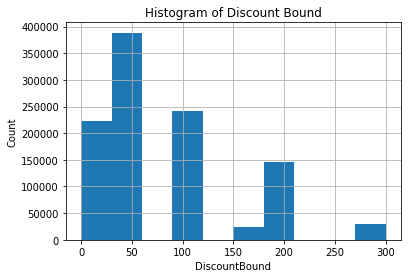

In [21]:
#Check the data distribution fitst
total_df['DiscountBound'].hist()
plt.title('Histogram of Discount Bound')
plt.xlabel('DiscountBound')
plt.ylabel('Count')
plt.show()

In [22]:
cuttingArr = np.array([-1,80,150,250,total_df.DiscountBound.max()+1])
total_df['DiscountBound_Group'] = pd.cut(total_df.DiscountBound, cuttingArr)

print(total_df.DiscountBound_Group.value_counts())
print('\n')
#encoding intervals into integer
DiscountBound_intervals = total_df.DiscountBound_Group.unique()
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[0],value = 0, inplace = True)
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[1],value = 1, inplace = True)
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[2],value = 2, inplace = True)
total_df.DiscountBound_Group.replace(to_replace = DiscountBound_intervals[3],value = 3, inplace = True)
print(total_df.DiscountBound_Group.value_counts())

(-1, 80]      611276
(80, 150]     266140
(150, 250]    146602
(250, 301]     29264
Name: DiscountBound_Group, dtype: int64


0    611276
2    266140
1    146602
3     29264
Name: DiscountBound_Group, dtype: int64


## User id features

In [23]:
Same_Merchant_User_received = total_df[['User_id','Merchant_id']]
Same_Merchant_User_received['temp'] = 1
Same_Merchant_User_received = Same_Merchant_User_received.groupby(['User_id','Merchant_id']).agg('sum').reset_index()
Same_Merchant_User_received.columns = ['User_id','Merchant_id','Same_Merchant_User_received']

total_df = pd.merge(total_df, Same_Merchant_User_received, on = ['User_id','Merchant_id'], how = 'left')

In [24]:
Total_Coupon_User_received = total_df.groupby(['User_id'])['Coupon_id'].count().reset_index()
Total_Coupon_User_received.columns = ['User_id', 'Total_Coupon_User_received']
total_df = pd.merge(total_df,Total_Coupon_User_received, on = ['User_id'], how = 'left')

In [25]:
Same_Coupon_User_received = total_df[['User_id', 'Coupon_id']]
Same_Coupon_User_received['temp'] = 1
Same_Coupon_User_received = Same_Coupon_User_received.groupby(['User_id','Coupon_id']).agg('sum').reset_index()
Same_Coupon_User_received.columns = ['User_id','Coupon_id','Same_Coupon_User_received']

total_df = pd.merge(total_df,Same_Coupon_User_received , on = ['User_id', 'Coupon_id'], how = 'left')

In [26]:
Same_Day_Same_Coupon_User_received = total_df[['User_id','Coupon_id','Date_received']]
Same_Day_Same_Coupon_User_received['temp'] = 1
Same_Day_Same_Coupon_User_received = Same_Day_Same_Coupon_User_received.groupby(['User_id','Coupon_id','Date_received']).agg('sum').reset_index()
Same_Day_Same_Coupon_User_received.columns = ['User_id','Coupon_id','Date_received','Same_Day_Same_Coupon_User_received']

total_df = pd.merge(total_df, Same_Day_Same_Coupon_User_received , on = ['User_id','Coupon_id','Date_received'], how = 'left')

In [27]:
Same_Day_Total_Coupon_User_received = total_df[['User_id','Date_received']]
Same_Day_Total_Coupon_User_received['temp'] = 1
Same_Day_Total_Coupon_User_received = Same_Day_Total_Coupon_User_received.groupby(['User_id','Date_received']).agg('sum').reset_index()
Same_Day_Total_Coupon_User_received.columns = ['User_id','Date_received', 'Same_Day_Total_Coupon_User_received']

total_df = pd.merge(total_df, Same_Day_Total_Coupon_User_received, on = ['User_id', 'Date_received'], how ='left')

In [28]:
User_Received_Coupon_DistcountBound_Mean = total_df.groupby(['User_id'])['DiscountBound'].mean().reset_index()
User_Received_Coupon_DistcountBound_Mean.columns = ['User_id','User_Received_Coupon_DistcountBound_Mean']

User_Received_Coupon_DistcountBound_Max = total_df.groupby(['User_id'])['DiscountBound'].max().reset_index()
User_Received_Coupon_DistcountBound_Max.columns = ['User_id','User_Received_Coupon_DistcountBound_Max']

User_Received_Coupon_DistcountBound_Min = total_df.groupby(['User_id'])['DiscountBound'].min().reset_index()
User_Received_Coupon_DistcountBound_Min.columns = ['User_id','User_Received_Coupon_DistcountBound_Min']

total_df = pd.merge(total_df,User_Received_Coupon_DistcountBound_Mean, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_DistcountBound_Max, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_DistcountBound_Min, on = ['User_id'], how = 'left')

In [29]:
User_Received_Coupon_MoneyCost_Mean = total_df.groupby(['User_id'])['MoneyCost'].mean().reset_index()
User_Received_Coupon_MoneyCost_Mean.columns = ['User_id','User_Received_Coupon_MoneyCost_Mean']

User_Received_Coupon_MoneyCost_Max = total_df.groupby(['User_id'])['MoneyCost'].max().reset_index()
User_Received_Coupon_MoneyCost_Max.columns = ['User_id','User_Received_Coupon_MoneyCost_Max']

User_Received_Coupon_MoneyCost_Min = total_df.groupby(['User_id'])['MoneyCost'].min().reset_index()
User_Received_Coupon_MoneyCost_Min.columns = ['User_id','User_Received_Coupon_MoneyCost_Min']

total_df = pd.merge(total_df,User_Received_Coupon_MoneyCost_Mean, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_MoneyCost_Max, on = ['User_id'], how = 'left')
total_df = pd.merge(total_df,User_Received_Coupon_MoneyCost_Min, on = ['User_id'], how = 'left')

In [30]:
User_Received_Coupon_DiscountRatio_Mean = total_df.groupby(['User_id'])['DiscountRatio'].mean().reset_index()
User_Received_Coupon_DiscountRatio_Mean.columns = ['User_id','User_Received_Coupon_DiscountRatio_Mean']
total_df = pd.merge(total_df,User_Received_Coupon_DiscountRatio_Mean, on = ['User_id'], how = 'left')

In [31]:
#This will take a long~ time
def CalMinReceivedGap(data):

    dates = data.split(':')
    if len(dates) == 1:
        return -1 #Means only received once
    MinGap = 365
    for i in range(0,len(dates)-1):
        cur_gap = pd.to_datetime( dates[i] , format = "%Y-%m-%d") - pd.to_datetime(dates[i+1] , format = "%Y-%m-%d")
        cur_gap = abs(cur_gap.days)
        if cur_gap < MinGap:
                MinGap = cur_gap
    return MinGap

Min_Coupon_received_gap = total_df[['User_id','Coupon_id','Date_received']]
Min_Coupon_received_gap.Date_received = Min_Coupon_received_gap.Date_received.astype('str')
Min_Coupon_received_gap =  Min_Coupon_received_gap.groupby(['User_id','Coupon_id'])['Date_received'].agg(lambda x : ':'.join(x)).reset_index()
Min_Coupon_received_gap['Min_Coupon_received_gap'] = Min_Coupon_received_gap.Date_received.apply(CalMinReceivedGap)
Min_Coupon_received_gap = Min_Coupon_received_gap.drop(['Date_received'], axis = 1)

total_df = pd.merge(total_df,Min_Coupon_received_gap,on = ['User_id','Coupon_id'], how ='left')
max_received_gap = total_df.Min_Coupon_received_gap.max()
total_df.Min_Coupon_received_gap = total_df.Min_Coupon_received_gap.map(lambda x : x if x != -1 else max_received_gap)

In [32]:
def CalMaxReceivedGap(data):
    dates = data.split(':')
    if len(dates) == 1:
        return -1 #Means only received once
    MaxGap = 0
    for i in range(0,len(dates)-1):
        cur_gap = pd.to_datetime( dates[i] , format = "%Y-%m-%d") - pd.to_datetime(dates[i+1] , format = "%Y-%m-%d")
        cur_gap = abs(cur_gap.days)
        if cur_gap > MaxGap:
                MaxGap = cur_gap
    return MaxGap


Max_Coupon_received_gap = total_df[['User_id','Coupon_id','Date_received']]
Max_Coupon_received_gap.Date_received = Max_Coupon_received_gap.Date_received.astype('str')
Max_Coupon_received_gap =  Max_Coupon_received_gap.groupby(['User_id','Coupon_id'])['Date_received'].agg(lambda x : ':'.join(x)).reset_index()
Max_Coupon_received_gap['Max_Coupon_received_gap'] = Max_Coupon_received_gap.Date_received.apply(CalMaxReceivedGap)
Max_Coupon_received_gap = Max_Coupon_received_gap.drop(['Date_received'], axis = 1)

total_df = pd.merge(total_df,Max_Coupon_received_gap,on = ['User_id','Coupon_id'], how ='left')
max_received_gap = total_df.Max_Coupon_received_gap.max()
total_df.Max_Coupon_received_gap = total_df.Max_Coupon_received_gap.map(lambda x : x if x != -1 else max_received_gap)
total_df.head(10)

,Coupon_id,Date_received,Distance,Merchant_id,User_id,Month_received,Day_received,Month_Cycle,CloseToJune,DiscountType,...,Same_Day_Total_Coupon_User_received,User_Received_Coupon_DistcountBound_Mean,User_Received_Coupon_DistcountBound_Max,User_Received_Coupon_DistcountBound_Min,User_Received_Coupon_MoneyCost_Mean,User_Received_Coupon_MoneyCost_Max,User_Received_Coupon_MoneyCost_Min,User_Received_Coupon_DiscountRatio_Mean,Min_Coupon_received_gap,Max_Coupon_received_gap
0,8591.0,2016-02-17,0.0,2632,1439408,2,17,0,103,1,...,1,46.000000,150,20,41.200000,130,19,0.933333,28,117
1,1078.0,2016-03-19,0.0,2632,1439408,3,19,0,71,1,...,1,46.000000,150,20,41.200000,130,19,0.933333,149,156
2,7610.0,2016-04-29,0.0,3381,1832624,4,29,0,31,1,...,1,200.000000,200,200,180.000000,180,180,0.900000,149,156
3,11951.0,2016-01-29,1.0,3381,2029232,1,29,0,121,1,...,1,83.333333,200,20,74.666667,180,19,0.894444,149,156
4,9776.0,2016-01-29,2.0,3381,2223968,1,29,0,121,1,...,1,10.000000,10,10,5.000000,5,5,0.500000,149,156
5,12034.0,2016-02-07,1.0,2099,73611,2,7,1,113,1,...,1,100.000000,100,100,90.000000,90,90,0.900000,149,156
6,5054.0,2016-04-21,10.0,1569,163606,4,21,0,39,1,...,1,200.000000,200,200,170.000000,170,170,0.850000,149,156
7,7802.0,2016-01-30,10.0,4833,3273056,1,30,0,120,1,...,1,200.000000,200,200,180.000000,180,180,0.900000,149,156
8,7610.0,2016-04-12,2.0,3381,94107,4,12,1,48,1,...,1,200.000000,200,200,180.000000,180,180,0.900000,149,156
9,7531.0,2016-03-27,0.0,8390,253750,3,27,0,63,1,...,1,25.000000,30,20,20.000000,25,15,0.791667,149,156


# Merchant features

In [33]:
Merchant_DiscountBound_mean = total_df.groupby(['Merchant_id'])['DiscountBound'].mean().reset_index()
Merchant_DiscountBound_mean.columns = ['Merchant_id','Merchant_DiscountBound_mean']

Merchant_DiscountBound_max = total_df.groupby(['Merchant_id'])['DiscountBound'].max().reset_index()
Merchant_DiscountBound_max.columns = ['Merchant_id','Merchant_DiscountBound_max']

Merchant_DiscountBound_min = total_df.groupby(['Merchant_id'])['DiscountBound'].min().reset_index()
Merchant_DiscountBound_min.columns = ['Merchant_id','Merchant_DiscountBound_min']

Merchant_DiscountRatio_max = total_df.groupby(['Merchant_id'])['DiscountRatio'].max().reset_index()
Merchant_DiscountRatio_max.columns = ['Merchant_id','Merchant_DiscountRatio_max']

Merchant_DiscountRatio_min = total_df.groupby(['Merchant_id'])['DiscountRatio'].min().reset_index()
Merchant_DiscountRatio_min.columns = ['Merchant_id','Merchant_DiscountRatio_min']

Merchant_DirectPriceCut_max = total_df.groupby(['Merchant_id'])['DirectPriceCut'].max().reset_index()
Merchant_DirectPriceCut_max.columns = ['Merchant_id','Merchant_DirectPriceCut_max']

Merchant_DirectPriceCut_min = total_df.groupby(['Merchant_id'])['DirectPriceCut'].min().reset_index()
Merchant_DirectPriceCut_min.columns = ['Merchant_id','Merchant_DirectPriceCut_min']

Merchant_DirectPriceCut_mean = total_df.groupby(['Merchant_id'])['DirectPriceCut'].mean().reset_index()
Merchant_DirectPriceCut_mean.columns = ['Merchant_id', 'Merchant_DirectPriceCut_mean']

Merchant_MoneyCost_mean = total_df.groupby(['Merchant_id'])['MoneyCost'].mean().reset_index()
Merchant_MoneyCost_mean.columns = ['Merchant_id', 'Merchant_MoneyCost_mean']

Merchant_MoneyCost_max = total_df.groupby(['Merchant_id'])['MoneyCost'].max().reset_index()
Merchant_MoneyCost_max.columns = ['Merchant_id', 'Merchant_MoneyCost_max']

Merchant_MoneyCost_min = total_df.groupby(['Merchant_id'])['MoneyCost'].min().reset_index()
Merchant_MoneyCost_min.columns = ['Merchant_id', 'Merchant_MoneyCost_min']

total_df = pd.merge(total_df,Merchant_DiscountBound_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DirectPriceCut_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_MoneyCost_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountBound_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountBound_min, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountRatio_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DiscountRatio_min, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DirectPriceCut_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_DirectPriceCut_min, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_MoneyCost_max, on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_MoneyCost_min, on = ['Merchant_id'], how = 'left')

In [34]:
Mcount = total_df.Merchant_id.value_counts().reset_index()
Mcount.columns = ['Merchant_id','Merchant_count']
Ccount = total_df.Coupon_id.value_counts().reset_index()
Ccount.columns = ['Coupon_id','Coupon_count']

total_df = pd.merge(total_df,Mcount,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Ccount,on = ['Coupon_id'], how = 'left')

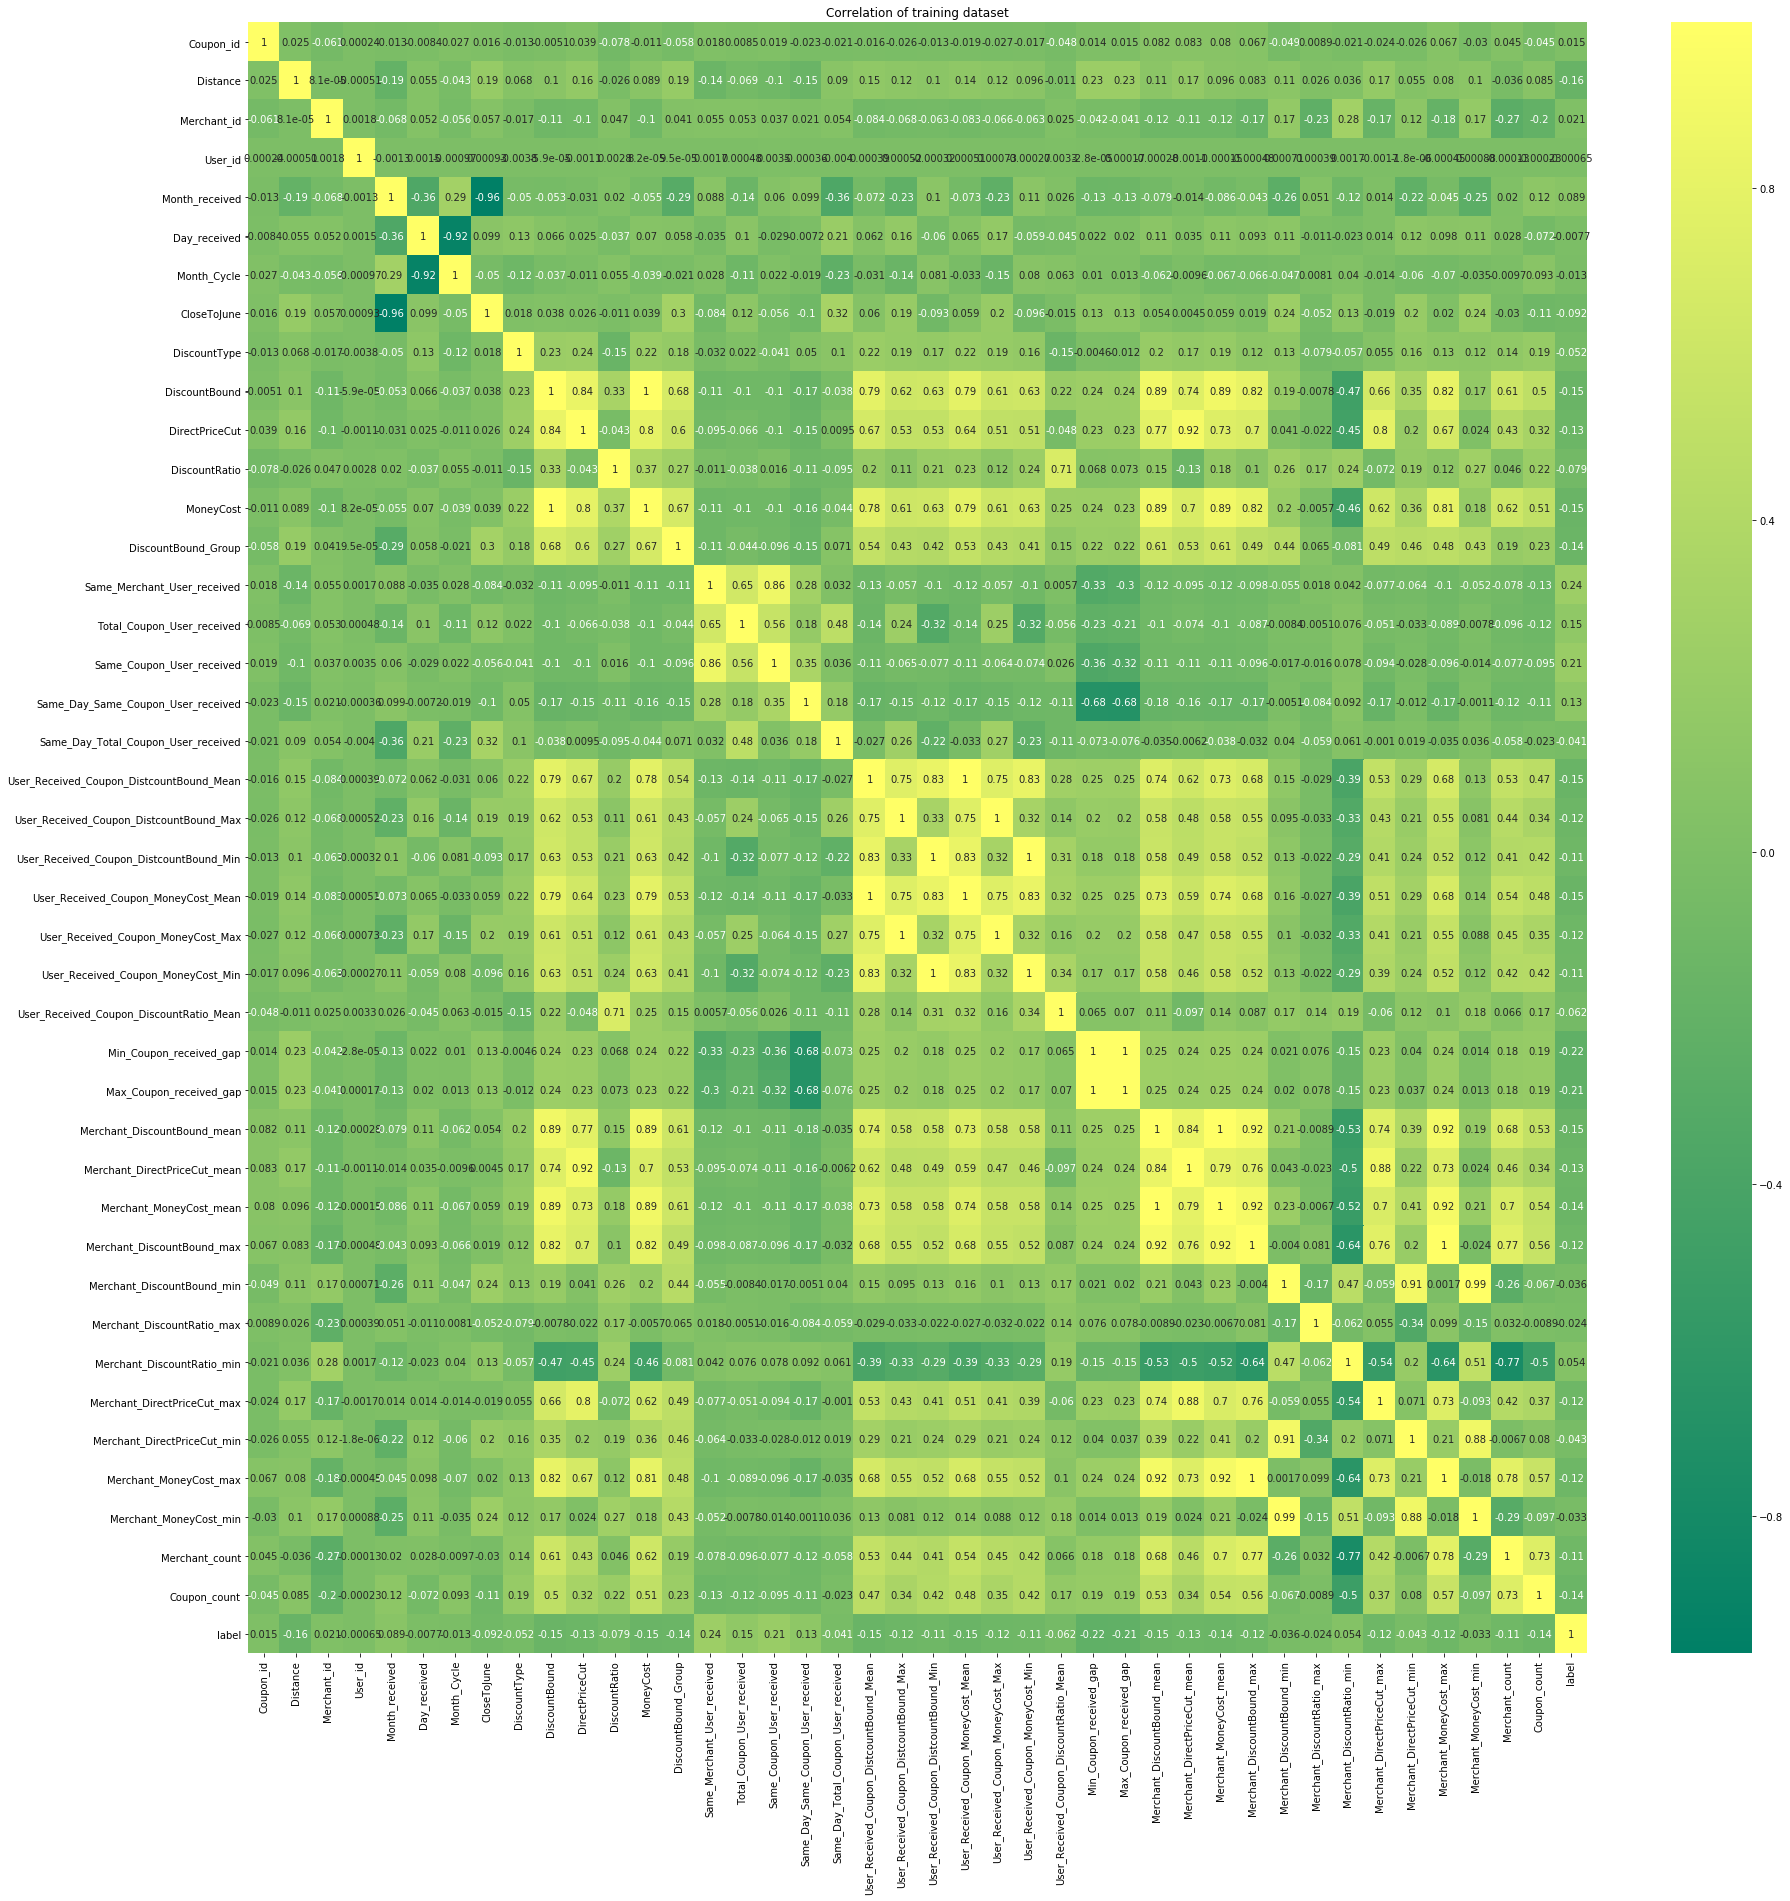

In [35]:
#Check the correlation again before fill the missing values of Distance
correlation = copy.deepcopy(total_df[:len(train_df)])
correlation = pd.concat([correlation, pd.DataFrame(train_label.values, columns = ['label'], index = correlation.index)], axis = 1)
corr = correlation.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, cmap = plt.cm.summer, annot = True)
plt.title('Correlation of training dataset')
plt.show()

## Distance features

In [36]:
#There are still some Distance values missing
#Let's check the ratio between missing values and non-missing values

print(f' Missing ratio of Distance : {np.sum(total_df.Distance.isnull()) / len(total_df)}')

 Missing ratio of Distance : 0.008023492284117644


In [37]:
total_df['Distance'] = total_df.groupby(['CloseToJune'])['Distance'].transform(lambda x : x.fillna(x.mode()[0]))
CheckMissingVals(total_df)
total_df.head(10)

,Coupon_id,Date_received,Distance,Merchant_id,User_id,Month_received,Day_received,Month_Cycle,CloseToJune,DiscountType,...,Merchant_DiscountBound_max,Merchant_DiscountBound_min,Merchant_DiscountRatio_max,Merchant_DiscountRatio_min,Merchant_DirectPriceCut_max,Merchant_DirectPriceCut_min,Merchant_MoneyCost_max,Merchant_MoneyCost_min,Merchant_count,Coupon_count
0,8591.0,2016-02-17,0.0,2632,1439408,2,17,0,103,1,...,20,20,0.95,0.95,1,1,19,19,43,31
1,1078.0,2016-03-19,0.0,2632,1439408,3,19,0,71,1,...,20,20,0.95,0.95,1,1,19,19,43,12
2,7610.0,2016-04-29,0.0,3381,1832624,4,29,0,31,1,...,300,10,0.90,0.50,30,5,270,5,122834,46729
3,11951.0,2016-01-29,1.0,3381,2029232,1,29,0,121,1,...,300,10,0.90,0.50,30,5,270,5,122834,26035
4,9776.0,2016-01-29,2.0,3381,2223968,1,29,0,121,1,...,300,10,0.90,0.50,30,5,270,5,122834,10345
5,12034.0,2016-02-07,1.0,2099,73611,2,7,1,113,1,...,100,100,0.90,0.90,10,10,90,90,16824,16824
6,5054.0,2016-04-21,10.0,1569,163606,4,21,0,39,1,...,200,0,0.90,0.70,50,0,170,0,33600,21402
7,7802.0,2016-01-30,10.0,4833,3273056,1,30,0,120,1,...,200,200,0.90,0.90,20,20,180,180,8321,6495
8,7610.0,2016-04-12,2.0,3381,94107,4,12,1,48,1,...,300,10,0.90,0.50,30,5,270,5,122834,46729
9,7531.0,2016-03-27,0.0,8390,253750,3,27,0,63,1,...,20,20,0.75,0.75,5,5,15,15,1047,690


In [38]:
User_Activity_Distance_Mean = total_df.groupby(['User_id'])['Distance'].mean().reset_index()
User_Activity_Distance_Mean.columns = ['User_id','User_Activity_Distance_Mean']
total_df = pd.merge(total_df,User_Activity_Distance_Mean,on = ['User_id'], how = 'left')

User_Activity_Distance_Max = total_df.groupby(['User_id'])['Distance'].max().reset_index()
User_Activity_Distance_Max.columns = ['User_id','User_Activity_Distance_Max']
total_df = pd.merge(total_df,User_Activity_Distance_Max,on = ['User_id'], how = 'left')

User_Activity_Distance_Min = total_df.groupby(['User_id'])['Distance'].min().reset_index()
User_Activity_Distance_Min.columns = ['User_id','User_Activity_Distance_Min']
total_df = pd.merge(total_df,User_Activity_Distance_Min,on = ['User_id'], how = 'left')

In [39]:
total_df['Bound_Distance'] = total_df['DiscountBound']+1 * (total_df['Distance']+1)
total_df['DiscountRatio_Distance'] = total_df['DiscountRatio'] * (total_df['Distance']+1)
total_df['MoneyCost_Distance'] = total_df['MoneyCost']+1 * (total_df['Distance']+1)
total_df['DirectPriceCut_Distance'] = total_df['DirectPriceCut']+1 / (total_df['Distance']+1) 

In [40]:
Merchant_Distance_mean = total_df.groupby(['Merchant_id'])['Distance'].mean().reset_index()
Merchant_Distance_mean.columns = ['Merchant_id','Merchant_Distance_mean']

Merchant_Distance_max = total_df.groupby(['Merchant_id'])['Distance'].max().reset_index()
Merchant_Distance_max.columns = ['Merchant_id','Merchant_Distance_max']

Merchant_Distance_min = total_df.groupby(['Merchant_id'])['Distance'].min().reset_index()
Merchant_Distance_min.columns = ['Merchant_id','Merchant_Distance_min']


Coupon_Distance_mean = total_df.groupby(['Coupon_id'])['Distance'].mean().reset_index()
Coupon_Distance_mean.columns = ['Coupon_id', 'Coupon_Distance_mean']

Coupon_Distance_max = total_df.groupby(['Coupon_id'])['Distance'].max().reset_index()
Coupon_Distance_max.columns = ['Coupon_id', 'Coupon_Distance_max']

Coupon_Distance_min = total_df.groupby(['Coupon_id'])['Distance'].min().reset_index()
Coupon_Distance_min.columns = ['Coupon_id', 'Coupon_Distance_min']

In [41]:
total_df = pd.merge(total_df,Merchant_Distance_mean,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_Distance_max,on = ['Merchant_id'], how = 'left')
total_df = pd.merge(total_df,Merchant_Distance_min,on = ['Merchant_id'], how = 'left')

total_df = pd.merge(total_df,Coupon_Distance_mean, on = ['Coupon_id'], how = 'left')
total_df = pd.merge(total_df,Coupon_Distance_max, on = ['Coupon_id'], how = 'left')
total_df = pd.merge(total_df,Coupon_Distance_min, on = ['Coupon_id'], how = 'left')

## Features encoding with label

In [42]:
'''
trainSet = copy.deepcopy(total_df[:len(train_df)])
trainSet = pd.concat([trainSet, pd.DataFrame(train_label.values, columns = ['label'], index = trainSet.index)], axis = 1)
trainSet.head(3)
'''

"\ntrainSet = copy.deepcopy(total_df[:len(train_df)])\ntrainSet = pd.concat([trainSet, pd.DataFrame(train_label.values, columns = ['label'], index = trainSet.index)], axis = 1)\ntrainSet.head(3)\n"

In [43]:
'''
Distance_Accepted_rate = trainSet.groupby(['Distance'])['label'].mean().reset_index()
Distance_Accepted_rate.columns = ['Distance','Distance_Accepted_rate']

DiscountBound_Accepted_rate = trainSet.groupby(['DiscountBound'])['label'].mean().reset_index()
DiscountBound_Accepted_rate.columns = ['DiscountBound', 'DiscountBound_Accepted_rate']

total_df = pd.merge(total_df, Distance_Accepted_rate , on = ['Distance'], how = 'left')
total_df = pd.merge(total_df, DiscountBound_Accepted_rate, on = ['DiscountBound'], how = 'left')

total_df.head(5)
'''

"\nDistance_Accepted_rate = trainSet.groupby(['Distance'])['label'].mean().reset_index()\nDistance_Accepted_rate.columns = ['Distance','Distance_Accepted_rate']\n\nDiscountBound_Accepted_rate = trainSet.groupby(['DiscountBound'])['label'].mean().reset_index()\nDiscountBound_Accepted_rate.columns = ['DiscountBound', 'DiscountBound_Accepted_rate']\n\ntotal_df = pd.merge(total_df, Distance_Accepted_rate , on = ['Distance'], how = 'left')\ntotal_df = pd.merge(total_df, DiscountBound_Accepted_rate, on = ['DiscountBound'], how = 'left')\n\ntotal_df.head(5)\n"

## Scale the features

In [44]:
total_df = total_df.drop(['Merchant_id','Coupon_id','Day_received','Month_received','User_id','Date_received'],axis = 1)

In [45]:
for col in total_df.columns:
    if (col != 'Distance_Accepted_rate') & (col != 'DiscountBound_Accepted_rate'):
        total_df[col] = MinMaxScaler().fit_transform(total_df[col].values.reshape(-1,1))        
total_df.head(10)

,Distance,Month_Cycle,CloseToJune,DiscountType,DiscountBound,DirectPriceCut,DiscountRatio,MoneyCost,DiscountBound_Group,Same_Merchant_User_received,...,Bound_Distance,DiscountRatio_Distance,MoneyCost_Distance,DirectPriceCut_Distance,Merchant_Distance_mean,Merchant_Distance_max,Merchant_Distance_min,Coupon_Distance_mean,Coupon_Distance_max,Coupon_Distance_min
0,0.0,0.0,0.693333,1.0,0.066667,0.01,0.949367,0.065517,0.000000,0.025641,...,0.064516,0.070159,0.063333,0.018919,0.137209,1.0,0.0,0.132258,1.0,0.0
1,0.0,0.0,0.480000,1.0,0.066667,0.01,0.949367,0.065517,0.000000,0.025641,...,0.064516,0.070159,0.063333,0.018919,0.137209,1.0,0.0,0.150000,1.0,0.0
2,0.0,0.0,0.213333,1.0,0.666667,0.20,0.886076,0.620690,0.333333,0.000000,...,0.645161,0.065482,0.600000,0.207207,0.292878,1.0,0.0,0.273712,1.0,0.0
3,0.1,0.0,0.813333,1.0,0.666667,0.20,0.886076,0.620690,0.333333,0.000000,...,0.648387,0.149673,0.603333,0.202252,0.292878,1.0,0.0,0.328865,1.0,0.0
4,0.2,0.0,0.813333,1.0,0.033333,0.05,0.379747,0.017241,0.000000,0.000000,...,0.038710,0.121609,0.023333,0.051952,0.292878,1.0,0.0,0.329812,1.0,0.0
5,0.1,1.0,0.760000,1.0,0.333333,0.10,0.886076,0.310345,0.666667,0.000000,...,0.325806,0.149673,0.303333,0.103153,0.235354,1.0,0.0,0.235354,1.0,0.0
6,1.0,0.0,0.266667,1.0,0.666667,0.30,0.822785,0.586207,0.333333,0.000000,...,0.677419,0.855940,0.600000,0.297297,0.624690,1.0,0.0,0.583305,1.0,0.0
7,1.0,0.0,0.806667,1.0,0.666667,0.20,0.886076,0.620690,0.333333,0.000000,...,0.677419,0.907390,0.633333,0.198198,0.725514,1.0,0.0,0.728360,1.0,0.0
8,0.2,1.0,0.326667,1.0,0.666667,0.20,0.886076,0.620690,0.333333,0.000000,...,0.651613,0.233863,0.606667,0.200601,0.292878,1.0,0.0,0.273712,1.0,0.0
9,0.0,0.0,0.426667,1.0,0.066667,0.05,0.696203,0.051724,0.000000,0.000000,...,0.064516,0.051450,0.050000,0.058559,0.066858,1.0,0.0,0.070870,1.0,0.0


In [46]:
#One hot encoding the discount type
total_df = pd.get_dummies(total_df, columns = ['DiscountType'], prefix = "DiscountType")
print(f' final shape of total data : {total_df.shape} ')

 final shape of total data : (1053282, 50) 


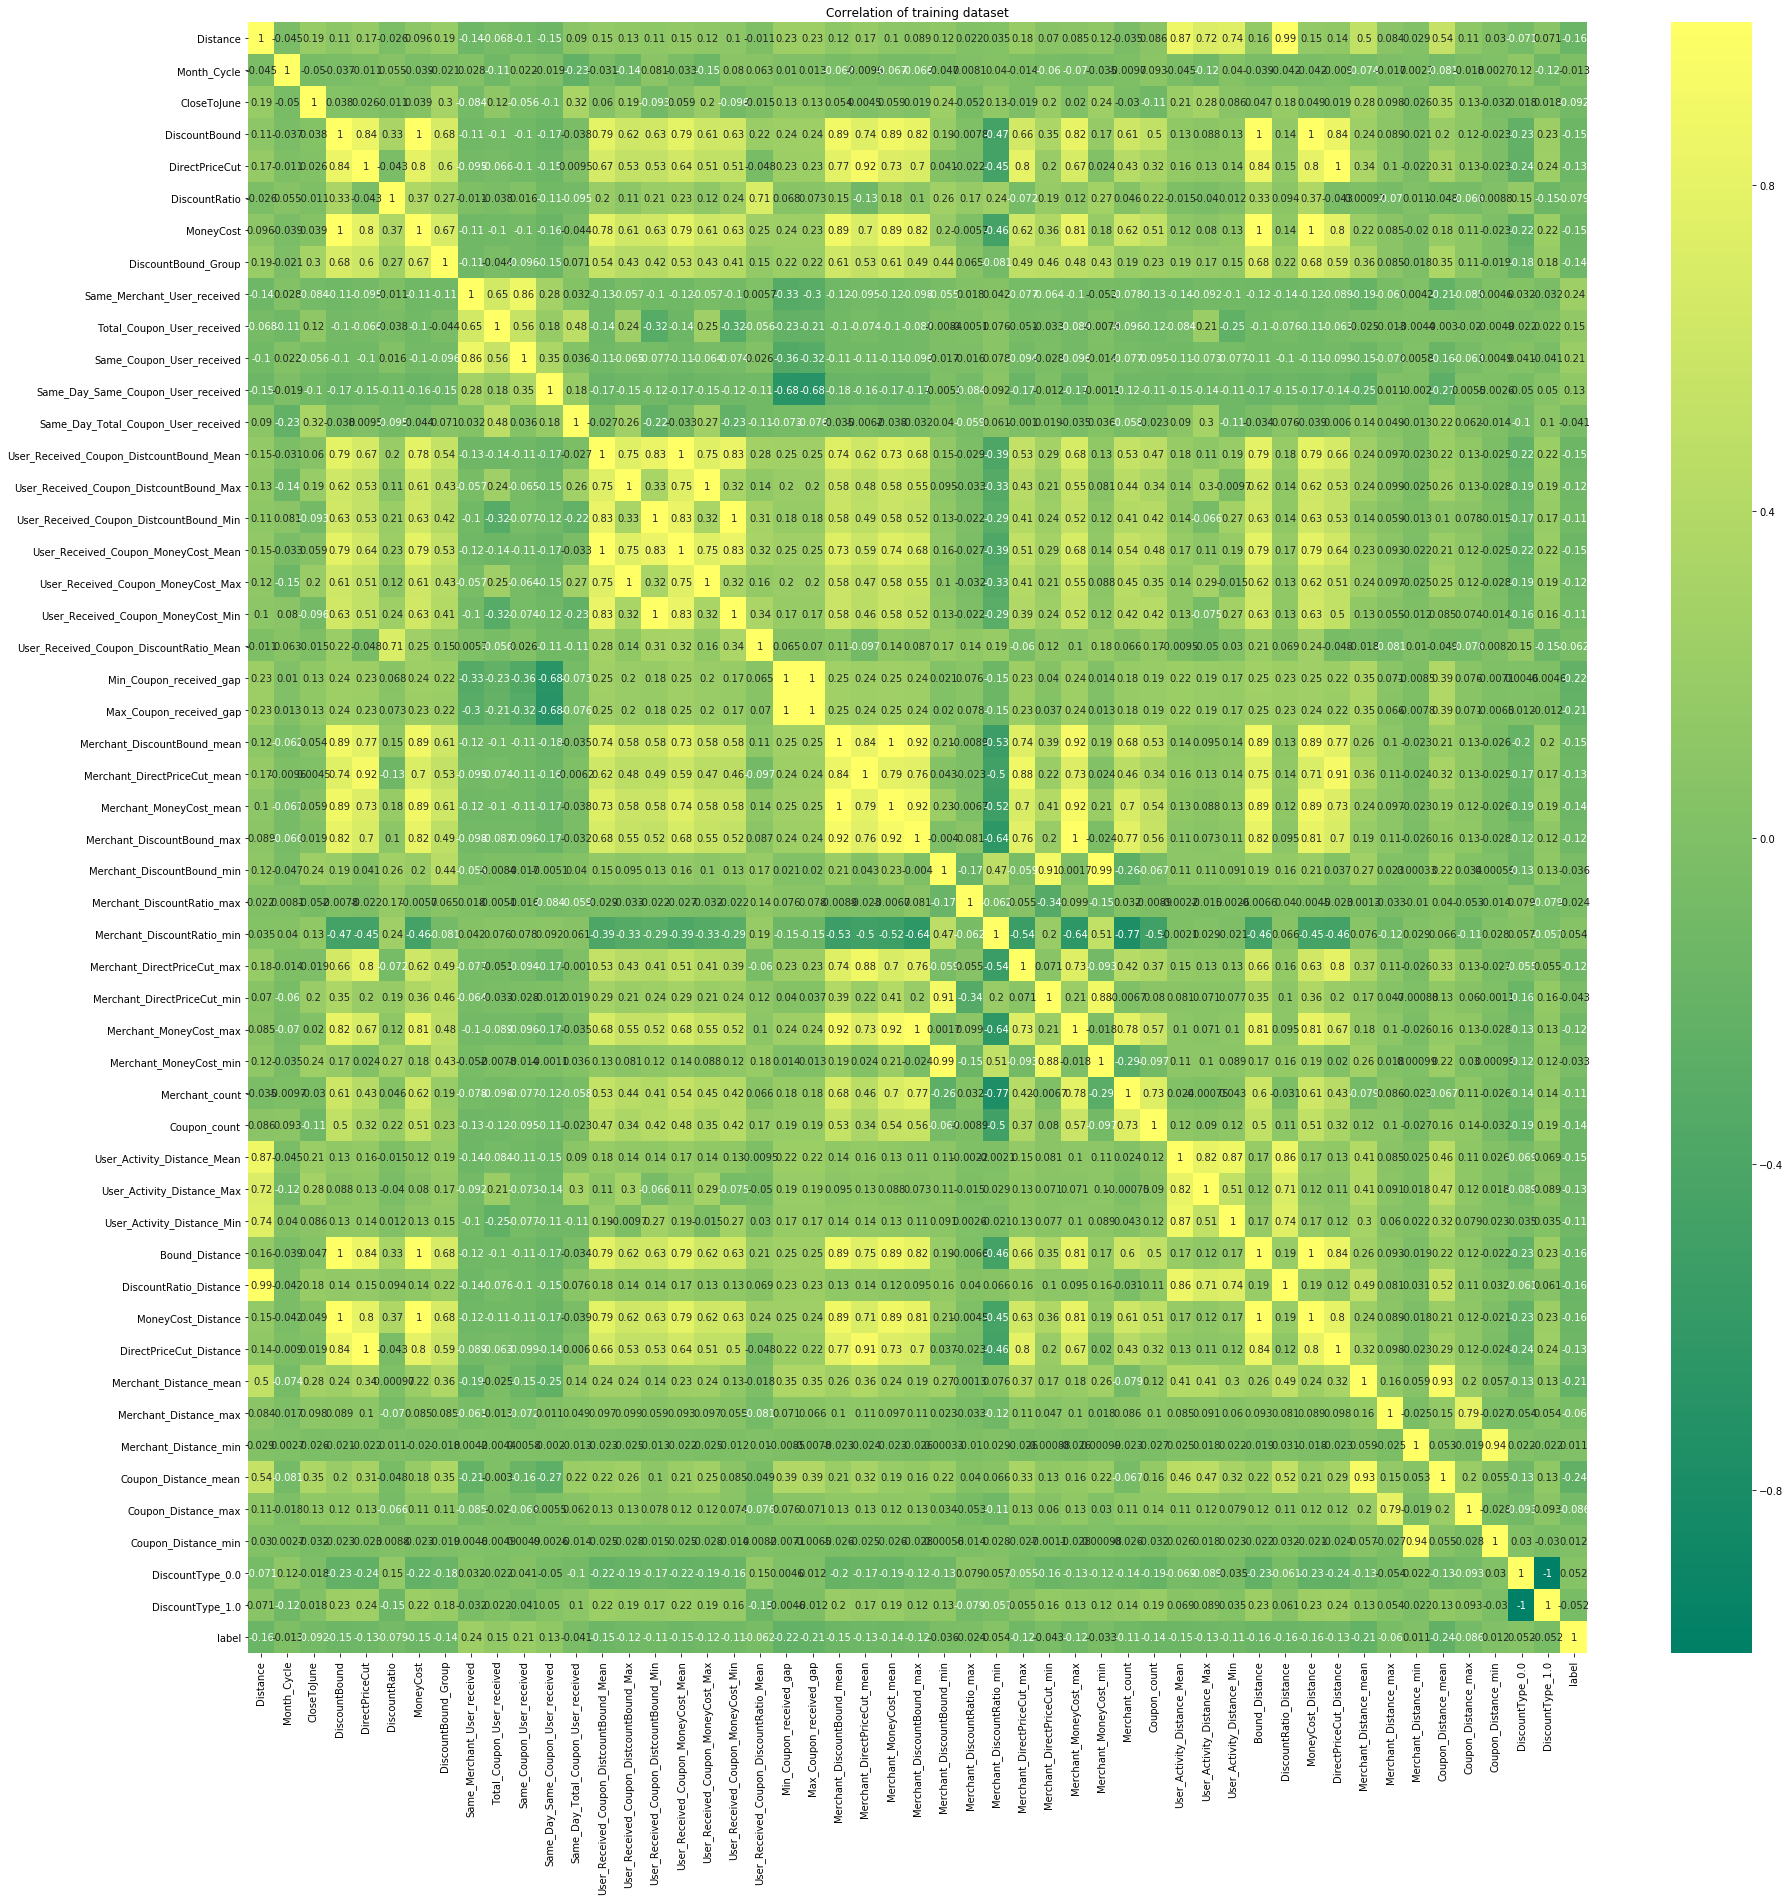

In [47]:
#Check the correlation again before fill the missing values of Distance
correlation = copy.deepcopy(total_df[:len(train_df)])
correlation = pd.concat([correlation, pd.DataFrame(train_label.values, columns = ['label'], index = correlation.index)], axis = 1)
corr = correlation.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, cmap = plt.cm.summer, annot = True)
plt.title('Correlation of training dataset')
plt.show()

# Model training & validation

In [48]:
train_x = total_df[:len(train_df)]
test_x = total_df[len(train_df):]

def tuneParamsRandom(classifier, params, train_x, train_y, cv = 5):
    rs = RandomizedSearchCV(classifier, params, n_iter = 20, scoring = 'roc_auc', n_jobs = -1, verbose = 0, cv=cv)
    rs.fit(train_x, train_y)
    
    return rs.best_params_, abs(rs.best_score_)

In [49]:
etParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_leaf':np.arange(1,6,2) }

rfParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_split':np.arange(2,20,2), 'min_samples_leaf':np.arange(1,6,2) }

abParams = {'n_estimators':np.arange(100,1100,50),'learning_rate':np.arange(0.01,0.2,0.05)}


lgbmcParams = {'n_estimators' : np.arange(400,1200,100), 'learning_rate' : np.arange(0.01,0.1,0.02),
               'num_leaves' : np.arange(2,48,4), 'max_depth' : np.arange(3,10,2),
               'subsample' : np.arange(0.3,0.8,0.1) }

gbcParams = {'n_estimators' : np.arange(400,1200,100) , 'learning_rate' : np.arange(0.01,0.1,0.02) 
             , 'min_samples_split' : np.arange(2,30,5), 'min_samples_leaf' : np.arange(2,32,4),
              'max_depth' : np.arange(3,8,2), 'subsample' : np.arange(0.3,0.8,0.1)}

xgbParams = {'max_depth':np.arange(3,8,1),'learning_rate':np.arange(0.01,0.1,0.02)
             ,'n_estimator': np.arange(1000,3000,100),'gamma':np.arange(0.01,0.1,0.02)}

lrParams = {'C':np.arange(0.01,1,0.05), 'max_iter' : np.arange(100,500,100)}

In [50]:
train_label.index = train_x.index
tuneSet = pd.concat([train_x,train_label], axis = 1)
trainSet = tuneSet.sample(frac=0.5)
trainSet.shape

(373484, 51)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(trainSet[trainSet.columns[trainSet.columns != 'label']],trainSet['label'], test_size = 0.3, random_state = 1234)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(261438, 50)
(261438,)
(112046, 50)
(112046,)


In [52]:
# LogisticRegression
'''
lr = LogisticRegression(random_state = 2019,n_jobs = -1)
lr_best_Params, lr_best_score = tuneParamsRandom(lr,lrParams,x_train,y_train)
print("LogisticRegression :",lr_best_Params,lr_best_score)
lr = LogisticRegression(**lr_best_Params,n_jobs = -1)
lr.fit(x_train,y_train)
lr_pred_val = lr.predict_proba(x_test)
auc_score = roc_auc_score(y_true = y_test, y_score = lr_pred_val[:,1])
acc = accuracy_score(y_true = y_test, y_pred = lr_pred_val.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))
lr = LogisticRegression(**lr_best_Params,n_jobs = -1,random_state = 2019)
lr.fit(train_x, train_label)
lr_pred = lr.predict_proba(test_x)[:,1]
'''

'\nlr = LogisticRegression(random_state = 2019,n_jobs = -1)\nlr_best_Params, lr_best_score = tuneParamsRandom(lr,lrParams,x_train,y_train)\nprint("LogisticRegression :",lr_best_Params,lr_best_score)\nlr = LogisticRegression(**lr_best_Params,n_jobs = -1)\nlr.fit(x_train,y_train)\nlr_pred_val = lr.predict_proba(x_test)\nauc_score = roc_auc_score(y_true = y_test, y_score = lr_pred_val[:,1])\nacc = accuracy_score(y_true = y_test, y_pred = lr_pred_val.argmax(axis=1))\nprint("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))\nlr = LogisticRegression(**lr_best_Params,n_jobs = -1,random_state = 2019)\nlr.fit(train_x, train_label)\nlr_pred = lr.predict_proba(test_x)[:,1]\n'

In [53]:
# GradientBoostingClassifier
'''
gbc = GradientBoostingClassifier(max_features = 'sqrt')
gbc_best_Params,gbc_best_score = tuneParamsRandom(gbc,gbcParams,x_train,y_train)
print("GradientBoostingClassifier:",gbc_best_Params,gbc_best_score)


gbc = GradientBoostingClassifier(**gbc_best_Params,max_features = 'sqrt')
gbc.fit(train_x, train_label)
gbc_pred = gbc.predict_proba(test_x)[:,1]

importances = pd.DataFrame(gbc.feature_importances_, columns = ['importances'], index = train_x.columns)
importances.importances.sort_values(ascending = False)
'''

'\ngbc = GradientBoostingClassifier(max_features = \'sqrt\')\ngbc_best_Params,gbc_best_score = tuneParamsRandom(gbc,gbcParams,x_train,y_train)\nprint("GradientBoostingClassifier:",gbc_best_Params,gbc_best_score)\n\n\ngbc = GradientBoostingClassifier(**gbc_best_Params,max_features = \'sqrt\')\ngbc.fit(train_x, train_label)\ngbc_pred = gbc.predict_proba(test_x)[:,1]\n\nimportances = pd.DataFrame(gbc.feature_importances_, columns = [\'importances\'], index = train_x.columns)\nimportances.importances.sort_values(ascending = False)\n'

In [54]:
# XGBClassifier
'''
xgb_best_Params,xgb_best_score = tuneParamsRandom(XGBClassifier(),xgbParams, x_train, y_train)
print("XGBClassifier:",xgb_best_Params,xgb_best_score)

xgb = XGBClassifier(**xgb_best_Params)
xgb.fit(train_x,train_label)
xgb_pred = xgb.predict_proba(test_x)[:,1]
'''

'\nxgb_best_Params,xgb_best_score = tuneParamsRandom(XGBClassifier(),xgbParams, x_train, y_train)\nprint("XGBClassifier:",xgb_best_Params,xgb_best_score)\n\nxgb = XGBClassifier(**xgb_best_Params)\nxgb.fit(train_x,train_label)\nxgb_pred = xgb.predict_proba(test_x)[:,1]\n'

In [55]:
# AdaBoost
'''
ab_best_Params,ab_best_score = tuneParamsRandom(AdaBoostClassifier(),abParams,val_x,val_y)
print("AdaBoost:",ab_best_Params,ab_best_score)
'''

'\nab_best_Params,ab_best_score = tuneParamsRandom(AdaBoostClassifier(),abParams,val_x,val_y)\nprint("AdaBoost:",ab_best_Params,ab_best_score)\n'

In [56]:
# RandomForest
'''
rf_best_Params,rf_best_score = tuneParamsRandom(RandomForestClassifier(),rfParams,val_x,val_y)
print("RandomForest:",rf_best_Params,rf_best_score)
'''

'\nrf_best_Params,rf_best_score = tuneParamsRandom(RandomForestClassifier(),rfParams,val_x,val_y)\nprint("RandomForest:",rf_best_Params,rf_best_score)\n'

In [57]:
# LGBMClassifier
lgbmc_best_Params, lgbmc_best_score = tuneParamsRandom(LGBMClassifier(),lgbmcParams,x_train,y_train)
print("LGBMClassifier:",lgbmc_best_Params,lgbmc_best_score)


lgbmc = LGBMClassifier(**lgbmc_best_Params)
lgbmc.fit(train_x,train_label)
lgbmc_pred = lgbmc.predict_proba(test_x)[:,1]

LGBMClassifier: {'subsample': 0.6000000000000001, 'num_leaves': 46, 'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.03} 0.9174666496226572


In [58]:
## Blending
#blending_pred = gbc_pred * 0.3 + lgbmc_pred * 0.7 

In [59]:
## Stacking
'''
from mlxtend.classifier import StackingClassifier
gbc = GradientBoostingClassifier(**gbc_best_Params)
lgbmc = LGBMClassifier(**lgbmc_best_Params)
xgb = XGBClassifier(**xgb_best_Params)

meta_estimator = LGBMClassifier()
stacking = StackingClassifier(classifiers = [gbc,lgbmc, xgb], meta_classifier = meta_estimator)
stacking.fit(train_x,train_label)
stacking_pred = stacking.predict_proba(test_x)[:,1]
'''

'\nfrom mlxtend.classifier import StackingClassifier\ngbc = GradientBoostingClassifier(**gbc_best_Params)\nlgbmc = LGBMClassifier(**lgbmc_best_Params)\nxgb = XGBClassifier(**xgb_best_Params)\n\nmeta_estimator = LGBMClassifier()\nstacking = StackingClassifier(classifiers = [gbc,lgbmc, xgb], meta_classifier = meta_estimator)\nstacking.fit(train_x,train_label)\nstacking_pred = stacking.predict_proba(test_x)[:,1]\n'

# Submission

In [60]:
test_ids = test_ids.loc[~test_ids.Coupon_id.isna()]

test_ids = pd.concat([test_ids, pd.DataFrame(lgbmc_pred, columns = ['label'], index = test_ids.index)] , axis = 1)

test_ids.loc[:,"User_id"] = test_ids["User_id"].apply(lambda x:str(int(x)))
test_ids.loc[:,"Coupon_id"] = test_ids["Coupon_id"].apply(lambda x:str(int(x)))
test_ids.loc[:,"Date_received"] = test_ids["Date_received"].apply(lambda x: str(int(x)))

test_ids["uid"] = test_ids[['User_id',"Coupon_id","Date_received"]].apply(lambda x: '_'.join(x.values), axis = 1)
test_ids.reset_index(drop = True, inplace = True)

In [61]:
submission = test_ids.groupby("uid", as_index = False).mean()
submission = submission[["uid","label"]]
submission.to_csv("v9.csv", header = ["uid", "label"], index = False)

submission.head(10)

,uid,label
0,1000020_2705_20160519,0.100367
1,1000020_8192_20160513,0.046992
2,1000065_1455_20160527,0.093216
3,1000085_8067_20160513,0.035538
4,1000086_2418_20160613,0.112292
5,1000140_8192_20160526,0.143077
6,1000169_2418_20160606,0.112058
7,1000297_13704_20160520,0.039650
8,1000324_13165_20160526,0.031601
9,1000338_10161_20160612,0.038176


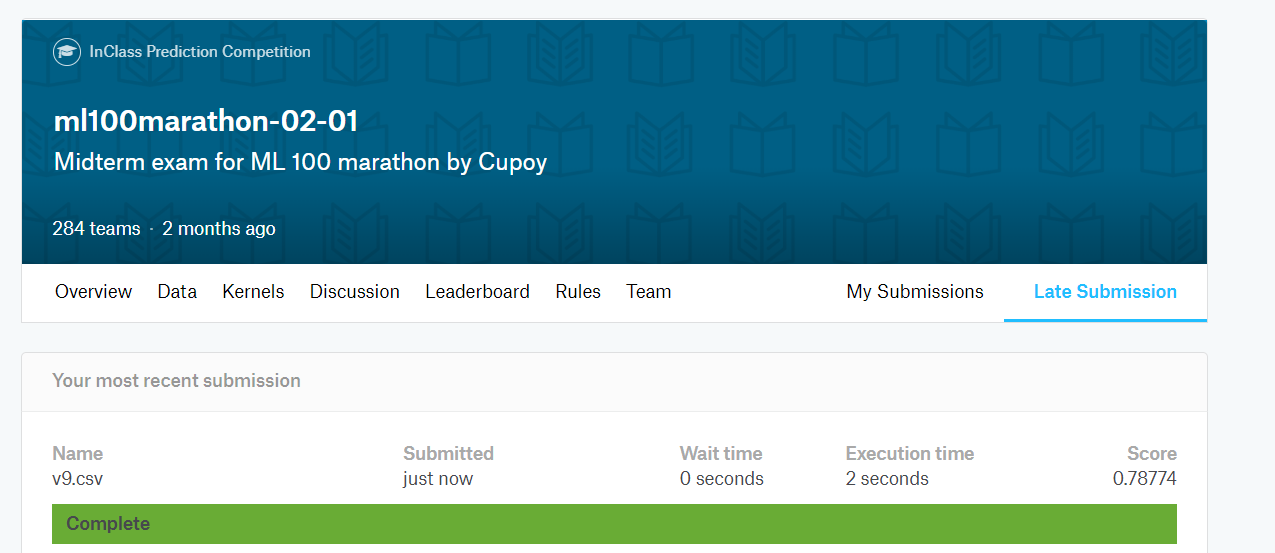